In [24]:
#https://stackoverflow.com/questions/68275615/what-is-the-right-way-to-check-if-a-type-hint-is-annotated
from inspect import signature
from typing import Literal, get_type_hints, get_args, get_origin
from decorator import decorator
from inspect import getargvalues, getfullargspec
import typing
@decorator
def literal_arg_checker(f, *args, **kwargs):
    sig = signature(f)
    print("f signature", sig)
    print(sig.bind(*args, **kwargs))
    bound_args = sig.bind(*args, **kwargs)
    params    = sig.parameters
    # sig.parameters should be idtcl to get_type_hints
    #params = get_type_hints(f, include_extras=True)
    print(params)
    for k_param, v_param in params.items():
        print(f"param_key: {k_param}, param_value:{v_param}")
        print("param_value.annotation=> ", v_param.annotation)
        annot_type = get_origin(v_param.annotation)
        #print(get_origin(h_param.annotation))
        print(get_args(v_param.annotation))
        print(get_origin(v_param.annotation))
        #if get_origin(h_param) is typing.Literal:
        #print(issubclass(h_param, Literal))
        if annot_type is typing.Literal:
            allow_word = get_args(v_param.annotation)
            if k_param in bound_args.arguments:               
                bound_value = bound_args.arguments[k_param]
                print(k_param, f" is a bound arg its value is {bound_value}")
                if not  bound_value in allow_word:
                    raise TypeError(f"parameter {k_param} value \"{bound_value}\" is not a valid Literal {allow_word}")
                
#            print("get origin=> ", get_origin(h_param))
#            print("It is a literal !! and its possible values are ")
#            print(get_args(h_param))
#            print("c value is ", param)
#            print(get_origin(h_param) is Literal)
    return f(*args, **kwargs)

fifou = Literal["background", "target"]

@literal_arg_checker
def f(x:fifou, y:int):
    return 'Passed'
f("backgrounds", 10)

f signature (x: Literal['background', 'target'], y: int)
<BoundArguments (x='backgrounds', y=10)>
OrderedDict([('x', <Parameter "x: Literal['background', 'target']">), ('y', <Parameter "y: int">)])
param_key: x, param_value:x: Literal['background', 'target']
param_value.annotation=>  typing.Literal['background', 'target']
('background', 'target')
typing.Literal
x  is a bound arg its value is backgrounds


TypeError: param x value "backgrounds" is not a valid Literal ('background', 'target')

#### graphviz installation hack on macOS

```sh
brew --prefix graphviz
python -m pip install \
    --global-option=build_ext \
    --global-option="-I$(brew --prefix graphviz)/include/" \
    --global-option="-L$(brew --prefix graphviz)/lib/" \
    pygraphviz
```

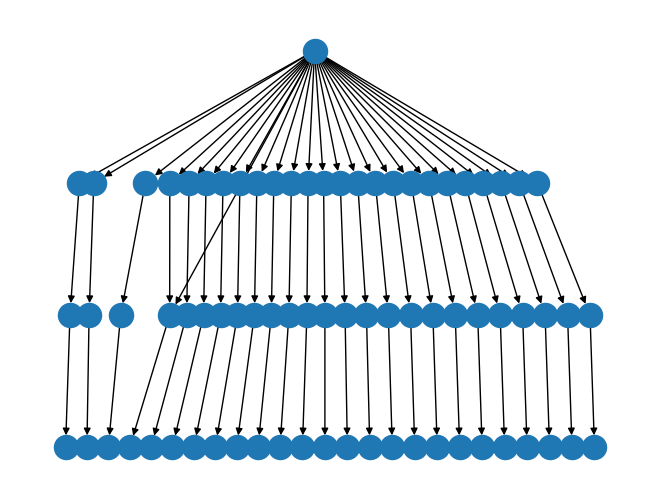

In [16]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_node("ROOT")

for i in range(25):
    G.add_node("Child_%i" % i)
    G.add_node("Grandchild_%i" % i)
    G.add_node("Greatgrandchild_%i" % i)

    G.add_edge("ROOT", "Child_%i" % i)
    G.add_edge("Child_%i" % i, "Grandchild_%i" % i)
    G.add_edge("Grandchild_%i" % i, "Greatgrandchild_%i" % i)

G.add_edge("ROOT", "Grandchild_3")
# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
#write_dot(G,'test.dot')

# same layout using matplotlib with no labels
#plt.title('draw_networkx')
pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True)
#plt.savefig('nx_test.png')

In [20]:
G.nodes('Grandchild_0')

NodeDataView({'ROOT': None, 'Child_0': None, 'Grandchild_0': None, 'Greatgrandchild_0': None, 'Child_1': None, 'Grandchild_1': None, 'Greatgrandchild_1': None, 'Child_2': None, 'Grandchild_2': None, 'Greatgrandchild_2': None, 'Child_3': None, 'Grandchild_3': None, 'Greatgrandchild_3': None, 'Child_4': None, 'Grandchild_4': None, 'Greatgrandchild_4': None, 'Child_5': None, 'Grandchild_5': None, 'Greatgrandchild_5': None, 'Child_6': None, 'Grandchild_6': None, 'Greatgrandchild_6': None, 'Child_7': None, 'Grandchild_7': None, 'Greatgrandchild_7': None, 'Child_8': None, 'Grandchild_8': None, 'Greatgrandchild_8': None, 'Child_9': None, 'Grandchild_9': None, 'Greatgrandchild_9': None, 'Child_10': None, 'Grandchild_10': None, 'Greatgrandchild_10': None, 'Child_11': None, 'Grandchild_11': None, 'Greatgrandchild_11': None, 'Child_12': None, 'Grandchild_12': None, 'Greatgrandchild_12': None, 'Child_13': None, 'Grandchild_13': None, 'Greatgrandchild_13': None, 'Child_14': None, 'Grandchild_14': N

In [1]:
#for devel add unigo dvl folder to path
import sys, os
sys.path.append(f"{os.getcwd()}/..")

from uniprot_redis.store import UniprotStore
store = UniprotStore()

from native_obo import tree_from_obo
tree = tree_from_obo('../alt_data/go-basic.obo')

ecoli_test_coll = store.get_protein_collection('ecoli_test')
tree.load_proteins('background', ecoli_test_coll)

## collection subset list creator
class Collector:
    def __init__(self, store, coll_name):
        self.store = store
        self.name = coll_name
    def __getitem__(self, subscript):
        iterator =  self.store.get_protein_collection(self.name)
        i = 0
        results = []
        for datum in iterator:
            if isinstance(subscript, slice):
                if i >= subscript.start and i < subscript.stop:
                    results.append(datum)
                if i == subscript.stop:
                    return results
            else:
                if i == subscript:
                    return datum
            i += 1

fuzzy_1 = Collector(store, 'ecoli_test')
measured_coll = fuzzy_1[10:110]
tree.load_proteins('measured', measured_coll)

In [2]:
print( tree.get_go_node('GO:0005887'), 
    tree.view_go_node('GO:0005887')
     )

NameError: name 'tree' is not defined

In [2]:
tree.percolate(percol_type="all")

In [4]:
len(tree.uniprot_omega[0])

0

In [5]:
tree.uniprot_omega

(set(), set())

In [32]:
from uniprot_redis.store.schemas import UniprotAC, UniprotDatum
import scipy.stats as stats 
from typing import Literal, Union, Iterator


OraNormalizer = Literal["background", "measured"]
def score_ora_tree(tree, delta_prot:Union[ Iterator[UniprotDatum], Iterator[UniprotAC]],
                         norm:OraNormalizer="background"):
    # TO DO :: type narrowing to UniprotAC[]
    #ac_omega_bkg, ac_omega_mea = ( set([ u.id for u in list(tree.uniprot_omega[0]) ]),
    #                               set([ u.id for u in list(tree.uniprot_omega[1]) ])
    #                       )
    omega_bkg, omega_mea = tree.uniprot_omega
    # consume iterator into persitent list of uniprotDatum
    delta = set([ _ for _ in delta_prot ])
    N = omega_bkg if norm == "background" else omega_mea
    print ("N size is ", len(N))
    for n in tree.concrete_nodes():
        # proteins abundant and path member
        n_path = n[f"perc_{norm}"]
        n_not_path = N - n_path
        s11 = delta & n_path
        if not s11:
            continue
        delta_0  = N - delta
        # proteins abundant and  not path member
        s12 = delta   & n_not_path
        s21 = delta_0 & n_path
        s22 = delta_0 & n_not_path
        
        """     | Path   | not(Path)
        --------------------------
        Delta_+ |   s11   |   s12
        -------------------------
        Delta_0 |   s21   |   s22
         
        """
        
        odd_ratio, p_value = stats.fisher_exact( [ ( len( s11 ) , len( s12 ) ),
                                                   ( len( s21 ) , len( s22 ) )
                                                ])
        print(n['_id'], n['name'], len(s11), odd_ratio, p_value)
        print([ ( len( s11 ) , len( s12 ) ),
                                                   ( len( s21 ) , len( s22 ) )
                                                ])



In [33]:
fuzzy_2 = Collector(store, 'ecoli_test')
delta_coll = fuzzy_2[25:45] # Slice is chosen to produce A SUBSET OF measured collection !!!

score_ora_tree(tree, delta_coll)

N size is  0
GO:0008150 biological_process 20 nan 1.0
[(20, 0), (0, 0)]
GO:0006281 DNA 1 nan 1.0
[(1, 0), (0, 0)]
GO:1902494 catalytic 3 nan 1.0
[(3, 0), (0, 0)]
GO:0022618 protein-RNA 1 nan 1.0
[(1, 0), (0, 0)]
GO:0000028 ribosomal 1 nan 1.0
[(1, 0), (0, 0)]
GO:0016758 hexosyltransferase 2 nan 1.0
[(2, 0), (0, 0)]
GO:0005488 binding 17 nan 1.0
[(17, 0), (0, 0)]
GO:0005886 plasma 5 nan 1.0
[(5, 0), (0, 0)]
GO:0140096 catalytic 2 nan 1.0
[(2, 0), (0, 0)]
GO:0140101 catalytic 4 nan 1.0
[(4, 0), (0, 0)]
GO:0000049 tRNA 4 nan 1.0
[(4, 0), (0, 0)]
GO:0003723 RNA 5 nan 1.0
[(5, 0), (0, 0)]
GO:0043604 amide 4 nan 1.0
[(4, 0), (0, 0)]
GO:1901566 organonitrogen 11 nan 1.0
[(11, 0), (0, 0)]
GO:1901605 alpha-amino 6 nan 1.0
[(6, 0), (0, 0)]
GO:0006575 cellular 1 nan 1.0
[(1, 0), (0, 0)]
GO:0000096 sulfur 1 nan 1.0
[(1, 0), (0, 0)]
GO:0006790 sulfur 1 nan 1.0
[(1, 0), (0, 0)]
GO:0019752 carboxylic 10 nan 1.0
[(10, 0), (0, 0)]
GO:1901564 organonitrogen 15 nan 1.0
[(15, 0), (0, 0)]
GO:0000097 sulfur

GO:0042558 pteridine-containing 1 nan 1.0
[(1, 0), (0, 0)]
GO:0009396 folic 1 nan 1.0
[(1, 0), (0, 0)]
GO:0006766 vitamin 1 nan 1.0
[(1, 0), (0, 0)]
GO:0006767 water-soluble 1 nan 1.0
[(1, 0), (0, 0)]
GO:0044248 cellular 1 nan 1.0
[(1, 0), (0, 0)]
GO:0006810 transport 3 nan 1.0
[(3, 0), (0, 0)]
GO:0051234 establishment 3 nan 1.0
[(3, 0), (0, 0)]
GO:0071702 organic 3 nan 1.0
[(3, 0), (0, 0)]
GO:0065007 biological 6 nan 1.0
[(6, 0), (0, 0)]
GO:0050896 response 7 nan 1.0
[(7, 0), (0, 0)]
GO:0009628 response 2 nan 1.0
[(2, 0), (0, 0)]
GO:0033554 cellular 4 nan 1.0
[(4, 0), (0, 0)]
GO:0016043 cellular 3 nan 1.0
[(3, 0), (0, 0)]
GO:0045229 external 2 nan 1.0
[(2, 0), (0, 0)]
GO:0017148 negative 1 nan 1.0
[(1, 0), (0, 0)]
GO:0007602 phototransduction 1 nan 1.0
[(1, 0), (0, 0)]
GO:0009583 detection 1 nan 1.0
[(1, 0), (0, 0)]
GO:0007603 phototransduction, 1 nan 1.0
[(1, 0), (0, 0)]
GO:0009584 detection 1 nan 1.0
[(1, 0), (0, 0)]
GO:0009416 response 1 nan 1.0
[(1, 0), (0, 0)]
GO:0019843 rRNA 2 n

In [9]:
tree.nodes['GO:0008150']

{'_id': 'GO:0008150',
 'name': 'biological_process',
 'alt_id': ['GO:0000004', 'GO:0007582', 'GO:0044699'],
 'def': 'A biological process is the execution of a genetically-encoded biological module or program. It consists of all the steps required to achieve the specific biological objective of the module. A biological process is accomplished by a particular set of molecular functions carried out by specific gene products (or macromolecular complexes), often in a highly regulated manner and in a particular temporal sequence.',
 'comment': 'Note',
 'subset': ['goslim_candida',
  'goslim_chembl',
  'goslim_metagenomics',
  'goslim_pir',
  'goslim_plant',
  'goslim_pombe',
  'goslim_yeast'],
 'synonym': ['biological process',
  'physiological process',
  'single organism process',
  'single-organism process'],
 'xref': 'Wikipedia:Biological_process'}

In [18]:
print(tree.root_ids)
tree.get_proteins('GO:0008150', k='target')

{'GO:0005575', 'GO:0003674', 'GO:0008150'}


{UniprotDatum(id='P00550', full_name='PTS system mannitol-specific EIICBA component', name='PTM3C_ECOLI', gene_name='mtlA', taxid=83333, sequence='MSSDIKIKVQSFGRFLSNMVMPNIGAFIAWGIITALFIPTGWLPNETLAKLVGPMITYLLPLLIGYTGGKLVGGERGGVVGAITTMGVIVGADMPMFLGSMIAGPLGGWCIKHFDRWVDGKIKSGFEMLVNNFSAGIIGMILAILAFLGIGPIVEALSKMLAAGVNFMVVHDMLPLASIFVEPAKILFLNNAINHGIFSPLGIQQSHELGKSIFFLIEANPGPGMGVLLAYMFFGRGSAKQSAGGAAIIHFLGGIHEIYFPYVLMNPRLILAVILGGMTGVFTLTILGGGLVSPASPGSILAVLAMTPKGAYFANIAGVCAAMAVSFVVSAILLKTSKVKEEDDIEAATRRMQDMKAESKGASPLSAGDVTNDLSHVRKIIVACDAGMGSSAMGAGVLRKKIQDAGLSQISVTNSAINNLPPDVDLVITHRDLTERAMRQVPQAQHISLTNFLDSGLYTSLTERLVAAQRHTANEEKVKDSLKDSFDDSSANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK', go=[GODatum(id='GO:0005886', evidence='ECO:0000314', term='C:plasma membrane'), GODatum(id='GO:0016301', evidence='ECO:0007669', term='F:kinase activity'), GODatum(id='GO:0022872', evidence='ECO:0007669', term='F:

In [1]:
for l_id in tree.leave_ids:
    print(l_id)

NameError: name 'tree' is not defined

In [2]:
tree.root_ids

{'GO:0003674', 'GO:0005575', 'GO:0008150'}

In [4]:
tree.get_proteins('GO:0005887', k='background')

{UniprotDatum(id='P07017', full_name='Methyl-accepting chemotaxis protein II', name='MCP2_ECOLI', gene_name='tar', taxid=83333, sequence='MINRIRVVTLLVMVLGVFALLQLISGSLFFSSLHHSQKSFVVSNQLREQQGELTSTWDLMLQTRINLSRSAVRMMMDSSNQQSNAKVELLDSARKTLAQAATHYKKFKSMAPLPEMVATSRNIDEKYKNYYTALTELIDYLDYGNTGAYFAQPTQGMQNAMGEAFAQYALSSEKLYRDIVTDNADDYRFAQWQLAVIALVVVLILLVAWYGIRRMLLTPLAKIIAHIREIAGGNLANTLTIDGRSEMGDLAQSVSHMQRSLTDTVTHVREGSDAIYAGTREIAAGNTDLSSRTEQQASALEETAASMEQLTATVKQNADNARQASQLAQSASDTAQHGGKVVDGVVKTMHEIADSSKKIADIISVIDGIAFQTNILALNAAVEAARAGEQGRGFAVVAGEVRNLASRSAQAAKEIKALIEDSVSRVDTGSVLVESAGETMNNIVNAVTRVTDIMGEIASASDEQSRGIDQVALAVSEMDRVTQQNASLVQESAAAAAALEEQASRLTQAVSAFRLAASPLTNKPQTPSRPASEQPPAQPRLRIAEQDPNWETF', go=[GODatum(id='GO:0051286', evidence='ECO:0000314', term='C:cell tip'), GODatum(id='GO:0098561', evidence='ECO:0000314', term='C:methyl accepting chemotaxis protein complex'), GODatum(id='GO:0005886', evidence='ECO:0000314', term='C:plasma membrane'), GODatum(id='GO:0042802', evidence='ECO:0000353', term

In [10]:
tree.get_go_node('GO:0008150')

{'_id': 'GO:0008150',
 'name': 'biological_process',
 'alt_id': ['GO:0000004', 'GO:0007582', 'GO:0044699'],
 'def': 'A biological process is the execution of a genetically-encoded biological module or program. It consists of all the steps required to achieve the specific biological objective of the module. A biological process is accomplished by a particular set of molecular functions carried out by specific gene products (or macromolecular complexes), often in a highly regulated manner and in a particular temporal sequence.',
 'comment': 'Note',
 'subset': ['goslim_candida',
  'goslim_chembl',
  'goslim_metagenomics',
  'goslim_pir',
  'goslim_plant',
  'goslim_pombe',
  'goslim_yeast'],
 'synonym': ['biological process',
  'physiological process',
  'single organism process',
  'single-organism process'],
 'xref': 'Wikipedia:Biological_process'}

In [7]:
for k in store.proteins:
    print(k)
    print(store.get_protein(k))
    break

print(store.get_protein('P0A7H3'))    

Q2MAG5
id='P0A7H3' full_name='DNA repair protein RecO' name='RECO_ECOLI' gene_name='recO' taxid=83333 sequence='MEGWQRAFVLHSRPWSETSLMLDVFTEESGRVRLVAKGARSKRSTLKGALQPFTPLLLRFGGRGEVKTLRSAEAVSLALPLSGITLYSGLYINELLSRVLEYETRFSELFFDYLHCIQSLAGVTGTPEPALRRFELALLGHLGYGVNFTHCAGSGEPVDDTMTYRYREEKGFIASVVIDNKTFTGRQLKALNAREFPDADTLRAAKRFTRMALKPYLGGKPLKSRELFRQFMPKRTVKTHYE' go=[GODatum(id='GO:0043590', evidence='ECO:0000318', term='C:bacterial nucleoid'), GODatum(id='GO:0006310', evidence='ECO:0000314', term='P:DNA recombination'), GODatum(id='GO:0006302', evidence='ECO:0000318', term='P:double-strand break repair'), GODatum(id='GO:0009314', evidence='ECO:0000315', term='P:response to radiation')] subcellular_location=[]
id='P0A7H3' full_name='DNA repair protein RecO' name='RECO_ECOLI' gene_name='recO' taxid=83333 sequence='MEGWQRAFVLHSRPWSETSLMLDVFTEESGRVRLVAKGARSKRSTLKGALQPFTPLLLRFGGRGEVKTLRSAEAVSLALPLSGITLYSGLYINELLSRVLEYETRFSELFFDYLHCIQSLAGVTGTPEPALRRFELALLGHLGYGVNFTHCAGSGEPVDDTMTYRYREEKGFIASVVIDNKTFTG

In [3]:
ecoli_xml="/Users/guillaumelaunay/work/databases/unIPROT/Ecoli_K12_complete_03052023.xml.gz"
protein_collection = store.load_uniprot_xml(file=ecoli_xml)

Acknowledged 0 entries (/Users/guillaumelaunay)
Acknowledged 4403 entries /Users/guillaumelaunay/work/databases/unIPROT/Ecoli_K12_complete_03052023.xml.gz
4403 entries added to store


In [4]:
store.save_collection('ecoli_test', protein_collection)

In [3]:
c = store.get_protein_collection('ecoli_test')
for _ in c:
    print(_)
    break

id='A5A616' full_name='Small protein MgtS' name='MGTS_ECOLI' gene_name='mgtS' taxid=83333 sequence='MLGNMNVFMAVLGIILFSGFLAAYFSHKWDD' go=[GODatum(id='GO:0005886', evidence='ECO:0000314', term='C:plasma membrane'), GODatum(id='GO:0010350', evidence='ECO:0000270', term='P:cellular response to magnesium starvation')] subcellular_location=['Cell inner membrane']


In [ ]:
## Build a tree
## Prune a tree vs p_iter


In [3]:
from native_obo import tree_from_obo
tree = tree_from_obo('../alt_data/go-basic.obo')

In [2]:
# id is an alias
x = tree.nodes['GO:0005887']
print(x)
# safe access to concrete go node 
x = tree.get_go_node('GO:0005887')
print("\nConcrete\n", x)

{'alias_to': {'_id': 'GO:0005886', 'name': 'plasma', 'alt_id': ['GO:0005887', 'GO:0005904'], 'def': 'The membrane surrounding a cell that separates the cell from its external environment. It consists of a phospholipid bilayer and associated proteins.', 'subset': ['goslim_agr', 'goslim_candida', 'goslim_chembl', 'goslim_drosophila', 'goslim_generic', 'goslim_metagenomics', 'goslim_mouse', 'goslim_plant', 'goslim_yeast', 'prokaryote_subset'], 'synonym': ['bacterial inner membrane', 'cell membrane', 'cellular membrane', 'cytoplasmic membrane', 'inner endospore membrane', 'integral component of plasma membrane', 'integral to plasma membrane', 'juxtamembrane', 'plasma membrane lipid bilayer', 'plasmalemma'], 'xref': ['NIF_Subcellular:sao1663586795', 'Wikipedia:Cell_membrane'], 'relationship': 'part_of', 'proteins': {UniprotDatum(id='P0AAC6', full_name='Modulator of FtsH protease YccA', name='YCCA_ECOLI', gene_name='yccA', taxid=83333, sequence='MDRIVSSSHDRTSLLSTHKVLRNTYFLLSLTLAFSAITATASTVLM

In [7]:
tree.nodes['GO:0005886']

{'name': 'plasma',
 'alt_id': ['GO:0005887', 'GO:0005904'],
 'def': 'The membrane surrounding a cell that separates the cell from its external environment. It consists of a phospholipid bilayer and associated proteins.',
 'subset': ['goslim_agr',
  'goslim_candida',
  'goslim_chembl',
  'goslim_drosophila',
  'goslim_generic',
  'goslim_metagenomics',
  'goslim_mouse',
  'goslim_plant',
  'goslim_yeast',
  'prokaryote_subset'],
 'synonym': ['bacterial inner membrane',
  'cell membrane',
  'cellular membrane',
  'cytoplasmic membrane',
  'inner endospore membrane',
  'integral component of plasma membrane',
  'integral to plasma membrane',
  'juxtamembrane',
  'plasma membrane lipid bilayer',
  'plasmalemma'],
 'xref': ['NIF_Subcellular:sao1663586795', 'Wikipedia:Cell_membrane'],
 'relationship': 'part_of',
 'proteins': {UniprotDatum(id='P08194', full_name='Glycerol-3-phosphate transporter', name='GLPT_ECOLI', gene_name='glpT', taxid=83333, sequence='MLSIFKPAPHKARLPAAEIDPTYRRLRWQIFLGIFF

In [6]:
tree.successors('GO:0005887')

In [6]:
#Get a node
any_node = tree.get_go_node('GO:0005886')
print(any_node)
# iter over its parent
for node_id in tree.predecessors('GO:0005886'):
    print(n)

{'_id': 'GO:0005886', 'name': 'plasma', 'alt_id': ['GO:0005887', 'GO:0005904'], 'def': 'The membrane surrounding a cell that separates the cell from its external environment. It consists of a phospholipid bilayer and associated proteins.', 'subset': ['goslim_agr', 'goslim_candida', 'goslim_chembl', 'goslim_drosophila', 'goslim_generic', 'goslim_metagenomics', 'goslim_mouse', 'goslim_plant', 'goslim_yeast', 'prokaryote_subset'], 'synonym': ['bacterial inner membrane', 'cell membrane', 'cellular membrane', 'cytoplasmic membrane', 'inner endospore membrane', 'integral component of plasma membrane', 'integral to plasma membrane', 'juxtamembrane', 'plasma membrane lipid bilayer', 'plasmalemma'], 'xref': ['NIF_Subcellular:sao1663586795', 'Wikipedia:Cell_membrane'], 'relationship': 'part_of', 'proteins': {UniprotDatum(id='P0AAC6', full_name='Modulator of FtsH protease YccA', name='YCCA_ECOLI', gene_name='yccA', taxid=83333, sequence='MDRIVSSSHDRTSLLSTHKVLRNTYFLLSLTLAFSAITATASTVLMLPSPGLILTLVGM

In [4]:
ecoli_test_coll = store.get_protein_collection('ecoli_test')
tree.annotate(ecoli_test_coll)

In [ ]:
tree.successor()

In [8]:
import networkx as nx
U = nx.DiGraph()

In [12]:
U.add_node('U', w =10)
U.add_node('Y', w =20)
U.add_edge('U', 'Y')
print(U.nodes['U'])
U.nodes['U']["rr"] = 1
print(U.nodes['U'])

{'w': 10}
{'w': 10, 'rr': 1}


In [10]:
type(U.nodes['U'])

dict

In [9]:
for _ in U.successors('U'):
    print("pp")

In [22]:
class Dummy:
    def __init__(self, name, v):
        self.name = name
        self.v = v
    def __hash__(self):
        return hash(self.name)
    def __repr__(self):
        return f"{self.name} :: {self.v}"

x,y = ( Dummy("milou", 13), Dummy("tintin",0) )
s1 = set([ x, y ])

In [23]:
#from copy import copy, deepcopy
s2 = s1.copy()
s3 = s1
s1.add(10)
print(s1)
print(s2)
print(s3)

{tintin :: 0, 10, milou :: 13}
{tintin :: 0, milou :: 13}
{tintin :: 0, 10, milou :: 13}


In [6]:
d1 ={"a" : 2, "b": 4}
d2 = d1.copy()
d1["a"] = 10
print(d1, d2)

{'a': 10, 'b': 4} {'a': 2, 'b': 4}
